# XAS Workflow Task 2

This notebook contains the second task of the XAS processing workflow. 

The break up of the task consist of the following steps 

|Task                            | Input                                         | Output
|-------------                   |-------------                                  |-----  
| Curve fitting||
| 1. Import data                |File: FeS2_larch.prj                              |
| 2. Import Crystal data        |File: FeS2.inp                                 |
| 3. Calculate Paths(Atoms+FEFF)||
| 4. Set path parameters        | Parameters:                                   |
|                                 |    amp  = 1                                   |
|                                 |    enot = 0                                   |
|                                 |    delr = 0                                   |
|                                 |    ss   = 0.003                               |
| 5. Run Fit                    |                                               |
| 6. Save project               ||
| 7. Verify fit results         ||
| 7.1 If not OK revise parameners and refit (go to 2.4)||
| 7.2 If OK Save project and outputs|                                           |File: FeS2_01.fpj

For more details about larch, see https://xraypy.github.io/xraylarch/xafs/


In [1]:
# managing athena files
from larch.io import create_athena, read_athena, extract_athenagroup

project_name = 'FeS2_larch.prj'


fes2_prj = read_athena(project_name)

group_keys = list(fes2_prj._athena_groups.keys())

group_names = {}

for group_key in group_keys:
    group_names[group_key] = group_key

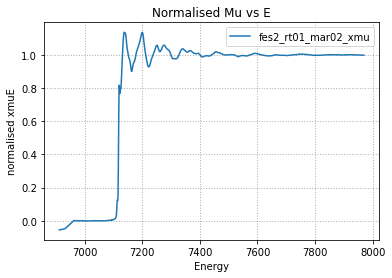

In [2]:
# required larch modules
# calculate pre-edge and post edge for normalisation
from larch.xafs import pre_edge
# perform background removal
from larch.xafs import autobk
# calculate fourier transform
from larch.xafs import xftf

%matplotlib inline
import matplotlib.pyplot as plt

 #######################################################
# |         Athena recalculates everything so we      | #
# |      need to create a function that calculates    | #
# V               all for each new group              V #
 #######################################################

def calc_with_defaults(xafs_group):
    # calculate mu and normalise with background extraction
    # should let the user specify the colums for i0, it, mu, iR. 
    if not hasattr(xafs_group, 'mu'):
        xafs_group = get_mu(xafs_group)
    # calculate pre-edge and post edge and add them to group
    # need to read parameters for pre-edge before background calculation with  
    # defaul values undo the work of previous step (setting pre-edge limits).
    pre_edge(xafs_group, pre1=xafs_group.bkg_params.pre1, pre2=xafs_group.bkg_params.pre2)
    #pre_edge(xafs_group)
    # perform background removal
    autobk(xafs_group) # using defaults so no additional parameters are passed
    # calculate fourier transform
    xftf(xafs_group)#, kweight=0.5, kmin=3.0, kmax=12.871, dk=1, kwindow='Hanning')
    return xafs_group


 #######################################################
# |       The code for plotting Nmu vs E repeats      | #
# |   so it is useful to have a plotting function     | #
# V            to reduce duplicated code              V #
 #######################################################
# plot mu vs flat normalised mu for selected groups
def plot_NxmuE_E_athena_prj(athena_project, group_keys, group_names,
                            title = "Normalised Mu vs E", xlimits = None,
                            ylimits = None):    
    # plot mu vs flat normalised mu for selected groups
    for group_key in group_keys:
        gr_0 = extract_athenagroup(athena_project._athena_groups[group_key])
        # recalculate normalisation
        calc_with_defaults(gr_0)
        plt.plot(gr_0.energy, gr_0.flat, label=group_names[group_key])

    # set plot format
    plt.xlabel("Energy")
    plt.ylabel("normalised xmuE" )
    plt.title(title)
    plt.grid(linestyle=':', linewidth=1) #show and format grid
    if xlimits != None:
        plt.xlim(xlimits[0],xlimits[1])
    if ylimits != None:
        plt.ylim(ylimits[0],ylimits[1])
    plt.legend()
    return plt, gr_0

# plot normalised mu on energy
# plot mu vs flat normalised mu for selected groups
plt, data_group = plot_NxmuE_E_athena_prj(fes2_prj, group_keys, group_names)
plt.show()


In [3]:
# larch does not include a means for running atoms
# need to run atoms to get input for feff and then
# calculate paths

# currently the fastest option is to run Artemis to
# obtain the input (.inp) file for feff from a '.cif'
# or '.inp' file

# get subprocess to run perl script
import subprocess

# get the input file
var = "FeS2.inp"

retcode = subprocess.call(["perl", "feff_inp.pl", var])
if retcode == 0:
    print("Passed!")
else:
    print("Failed!")

# run feff and get the paths
from larch.xafs.feffrunner import feff6l
#feff6l(folder='.', feffinp='feff.inp', verbose=True)
feff6l(folder = './fes2_feff',feffinp='fes2_feff.inp' )

Passed!
 : ======== running Feff module C:\Users\scman1\Anaconda3\envs\python36\lib\site-packages\larch\bin\win32\feff6l.exe ========
 : Feff 6L.02
 : name:     Iron sulfide (pyrite)
 : formula:  FeS_2
 : refer1:   Elliot (1960) J.Chem. Phys. 33(3), 903.
 : Calculating potentials and phases...
 : free atom potential and density for atom type    0
 : free atom potential and density for atom type    1
 : free atom potential and density for atom type    2
 : overlapped potential and density for unique potential    0
 : overlapped potential and density for unique potential    1
 : overlapped potential and density for unique potential    2
 : muffin tin radii and interstitial parameters
 : phase shifts for unique potential    0
 : phase shifts for unique potential    1
 : phase shifts for unique potential    2
 : Preparing plane wave scattering amplitudes...
 : nncrit in prcrit       9
 : Searching for paths...
 : Rmax  6.0000  keep and heap limits   0.0000000   0.0000000
 : Preparing neigh

<External Feff Group: ./fes2_feff\fes2_feff.inp>

In [4]:
# set parameters 
# example Using Larch with python3
from larch import Interpreter
import larch_plugins as lp

session = Interpreter()

# Equivalent to setting GDS parameters in Artemis
# or the parameters in the larch example
#gds.alpha = param(1e-07, vary=True)
#gds.amp = param(1, vary=True)
#gds.enot = param(1e-07, vary=True)
#gds.ss = param(0.003, vary=True)
#gds.ss2 = param(0.003, vary=True)
#gds.ssfe = param(0.003, vary=True)
#gds.ss3 = param(expr='ss2')

gds = lp.fitting.param_group(alpha = lp.fitting.param(1e-07, vary=True),
                             amp   = lp.fitting.param(1, vary=True),
                             enot  = lp.fitting.param(1e-07, vary=True),
                             ss    = lp.fitting.param(0.003, vary=True),
                             ss2   = lp.fitting.param(0.003, vary=True),
                             ssfe  = lp.fitting.param(0.003, vary=True),
                             ss3   = lp.fitting.param(expr='ss2'), _larch=session)



In [5]:
# select paths
path1 = lp.xafs.FeffPathGroup(filename = 'fes2_feff/feff0001.dat',
                              s02      = 'amp',
                              e0       = 'enot',
                              sigma2   = 'ss2',
                              deltar   = 'alpha*reff',
                              _larch=session)

In [6]:
# run fit
# create the transform grup (prepare the fit space).
trans = lp.xafs.TransformGroup(fitspace='r', kmin=3, kmax=14, kw=2, dk=1, window='hanning', rmin=1.4,
                               rmax=3.0, _larch=session)

dset = lp.xafs.FeffitDataSet(data=data_group, pathlist=[path1], transform=trans, _larch=session)

out = lp.xafs.feffit(gds, dset, _larch=session)

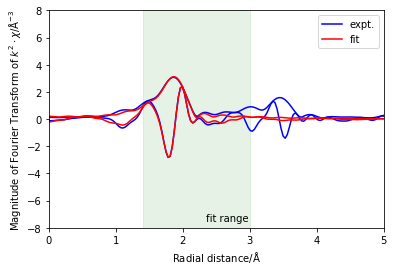

In [9]:
fig = plt.figure()
plt.plot(dset.data.r, dset.data.chir_mag, color='b')
plt.plot(dset.data.r, dset.data.chir_re, color='b', label='expt.')
plt.plot(dset.model.r, dset.model.chir_mag, color='r')
plt.plot(dset.model.r, dset.model.chir_re, color='r', label='fit')
plt.ylabel("Magnitude of Fourier Transform of $k^2 \cdot \chi$/$\mathrm{\AA}^{-3}$")
plt.xlabel("Radial distance/$\mathrm{\AA}$")
plt.xlim(0, 5)
plt.ylim(-8, 8)
plt.fill([1.4, 1.4, 3.0, 3.0],[-8, 8, 8, -8], color='g',alpha=0.1)
plt.text(2.35, -7.5, 'fit range')
plt.legend()
plt.show()

In [10]:
vars(gds)

{'_larch': <larch.interpreter.Interpreter at 0x1163f530>,
 '__params__': Parameters([('alpha',
              <Parameter 'alpha', value=0.0027878265696109554, bounds=[-inf:inf]>),
             ('amp',
              <Parameter 'amp', value=0.7119971812076786, bounds=[-inf:inf]>),
             ('enot',
              <Parameter 'enot', value=4.289578119174364, bounds=[-inf:inf]>),
             ('ss', <Parameter 'ss', value=0.003, bounds=[-inf:inf]>),
             ('ss2',
              <Parameter 'ss2', value=0.0028990126310998554, bounds=[-inf:inf]>),
             ('ssfe', <Parameter 'ssfe', value=0.003, bounds=[-inf:inf]>),
             ('ss3',
              <Parameter 'ss3', value=0.0028990126310998554, bounds=[-inf:inf], expr='ss2'>)]),
 '__name__': '0x1327c110',
 '__exprsave__': {'ss3': 'ss2'},
 'alpha': <Parameter 'alpha', value=0.0027878265696109554, bounds=[-inf:inf]>,
 'amp': <Parameter 'amp', value=0.7119971812076786, bounds=[-inf:inf]>,
 'enot': <Parameter 'enot', value=4.2895781

In [11]:
vars(path1)

{'__name__': 'FeffPath: fes2_feff/feff0001.dat',
 '_larch': <larch.interpreter.Interpreter at 0x1163f530>,
 'filename': 'fes2_feff/feff0001.dat',
 'params': Parameters([('degen__puglgrkiw',
              <Parameter 'degen__puglgrkiw', value=6.0 (fixed), bounds=[-inf:inf]>),
             ('s02__puglgrkiw',
              <Parameter 's02__puglgrkiw', value=0.7119971812076786, bounds=[-inf:inf], expr='amp'>),
             ('e0__puglgrkiw',
              <Parameter 'e0__puglgrkiw', value=4.289578119174364, bounds=[-inf:inf], expr='enot'>),
             ('ei__puglgrkiw',
              <Parameter 'ei__puglgrkiw', value=0.0 (fixed), bounds=[-inf:inf]>),
             ('deltar__puglgrkiw',
              <Parameter 'deltar__puglgrkiw', value=0.006291009436984083, bounds=[-inf:inf], expr='alpha*reff'>),
             ('sigma2__puglgrkiw',
              <Parameter 'sigma2__puglgrkiw', value=0.0028990126310998554, bounds=[-inf:inf], expr='ss2'>),
             ('third__puglgrkiw',
              <Param